# Homework 2

## Формат сдачи

* этот ipynb файл с кодом
* "checkpoint" файл из `torch.save(model.state_dict(), ...)` который содержит веса модели для задачи 1 и поможет удостовериться в точности на валидации
* имеется возможность перезапустить весь ipynb файл с запуском training рутины, чтобы убедиться в финальном результате

# Задача 1 - Train your own model (6 баллов)

В этом задании вы построете сверточную нейросеть (CNN) для решения Tiny ImageNet классификации. Постарайтесь добиться максимальной точности на валидации.

### Оценивание

* За преодоление каждого порога даётся 1 балл
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
    
### Ограничения

* Нельзя использовать предобученные нейросети. Сами архитектуры использовать можно.

### Советы

* Одно изменение в один момент времени
* Используйте GPU
* Логируйте промежуточный результаты, например в TensorBoard

In [0]:
import os
import argparse

In [0]:
! git clone https://github.com/seshuad/IMagenet

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.


In [0]:
 # file where image2class mapping is present
fp = open('IMagenet/tiny-imagenet-200/val/val_annotations.txt', "r")  # open file in read mode
data = fp.readlines()  # read line by line

# Create a dictionary with image names as key and corresponding classes as values
val_img_dict = {}
for line in data:
    words = line.split("\t")
    val_img_dict[words[0]] = words[1]
fp.close()

In [0]:
val_img_dict

In [0]:
path = 'IMagenet/tiny-imagenet-200/val/'
path_img = 'IMagenet/tiny-imagenet-200/val/images/'
for img, folder in val_img_dict.items():
    newpath = (os.path.join(path, folder))
    if not os.path.exists(newpath):  # check if folder exists
        os.makedirs(newpath)

    if os.path.exists(os.path.join(path_img, img)):  # Check if image exists in default directory
        os.rename(os.path.join(path_img, img), os.path.join(newpath, img))


In [0]:
!rm IMagenet/tiny-imagenet-200/val/val_annotations.txt

In [0]:
!rm -r IMagenet/tiny-imagenet-200/val/images

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import torchvision
import torch
from torchvision import transforms

In [0]:
from torch.utils.tensorboard import SummaryWriter

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
import torchvision.models as models

In [0]:
torch.cuda.is_available()

True

In [0]:
!nvidia-smi

Sat Feb 22 12:12:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    52W / 250W |   4675MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
preprocess = transforms.Compose([
    #transforms.Resize(256),
  
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [0]:
preprocess_train = transforms.Compose([
            transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
        ])

In [0]:
train_dataset = torchvision.datasets.ImageFolder('IMagenet/tiny-imagenet-200/train', transform=preprocess_train) #dataset
val_dataset = torchvision.datasets.ImageFolder('IMagenet/tiny-imagenet-200/val', transform=preprocess)
#test_dataset = torchvision.datasets.ImageFolder('IMagenet/tiny-imagenet-200/test', transform=preprocess)

In [0]:
val_dataset[9999][1]

199

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


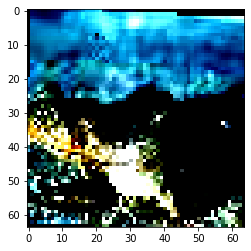

In [0]:
plt.imshow(  train_dataset[1000][0].permute(1, 2, 0)  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


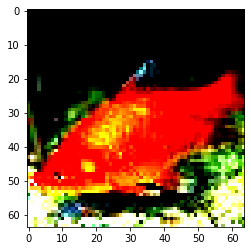

In [0]:
plt.imshow(  val_dataset[9][0].permute(1, 2, 0)  )

In [0]:
batch_size = 240
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1 )

In [0]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [0]:
test_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=1)

In [0]:

model = models.resnet18(pretrained = False)

In [0]:
model

In [0]:
model.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
model.maxpool = nn.Sequential()
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc.out_features = 200

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model.cuda()(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [0]:
from torch.optim import lr_scheduler
import copy

In [0]:
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

In [0]:
num_epochs = 50 # total amount of full passes over training data

import time

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    exp_lr_scheduler.step()
    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    best_acc = np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

Epoch 1 of 50 took 215.924s
  training loss (in-iteration): 	4.892179
  validation accuracy: 			7.53 %
Epoch 2 of 50 took 216.049s
  training loss (in-iteration): 	4.175284
  validation accuracy: 			16.23 %
Epoch 3 of 50 took 215.910s
  training loss (in-iteration): 	3.568829
  validation accuracy: 			24.07 %
Epoch 4 of 50 took 215.999s
  training loss (in-iteration): 	3.146005
  validation accuracy: 			29.92 %
Epoch 5 of 50 took 216.162s
  training loss (in-iteration): 	2.835946
  validation accuracy: 			33.22 %
Epoch 6 of 50 took 216.385s
  training loss (in-iteration): 	2.594577
  validation accuracy: 			38.22 %
Epoch 7 of 50 took 216.461s
  training loss (in-iteration): 	2.395182
  validation accuracy: 			39.81 %
Epoch 8 of 50 took 216.052s
  training loss (in-iteration): 	1.969322
  validation accuracy: 			46.44 %
Epoch 9 of 50 took 215.889s
  training loss (in-iteration): 	1.857694
  validation accuracy: 			47.07 %
Epoch 10 of 50 took 216.110s
  training loss (in-iteration): 	1.7

KeyboardInterrupt: ignored

In [0]:
torch.save(model.state_dict(), 'checkpoint_norm_aug_sgd.pth')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
model.load_state_dict(torch.load('checkpoint_norm_aug_sgd.pth'))

<All keys matched successfully>

In [0]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    test_batch_acc.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))


test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 70:
    print("Perfect")
elif test_accuracy * 100 > 50:
    print("Excellent")
elif test_accuracy * 100 > 40:
    print("Good x3")
elif test_accuracy * 100 > 30:
    print("Good x2")
elif test_accuracy * 100 > 20:
    print("Good")
else:
    print("We need more magic!")

Final results:
  test accuracy:		47.85 %
Good x3


# Задача 2 - Transfer Learning (1 балл)

Выберите любую предобученную модель из torchvison (https://pytorch.org/docs/stable/torchvision/models.html). Сделайте transfer learning для датасета из задачи 1. Выведите точность на валидации.

In [0]:
model = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
model

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.flatten(1)

In [0]:
model.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
model.maxpool = nn.Sequential()
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Sequential(nn.Linear(512,300),
nn.ReLU(),
nn.Linear(300,200)
)

In [0]:
for parameter in model.parameters():
    parameter.requires_grad_(True)

trainable_parameters = list(model.fc.parameters())
for parameter in trainable_parameters:
    parameter.requires_grad_(True)

In [0]:
from torch.optim import lr_scheduler
import copy

In [0]:
train_loss = []
opt = torch.optim.Adam(trainable_parameters, lr=0.001, weight_decay = 0.0001) # lr=0.01, weight_decay = 0.001
loss = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

val_accuracy = []
train_loss = []

In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda() 
    logits = model.cuda()(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [0]:
num_epochs = 50 # total amount of full passes over training data

import time

for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

Epoch 1 of 50 took 223.772s
  training loss (in-iteration): 	4.617737
  validation accuracy: 			11.54 %
Epoch 2 of 50 took 214.241s
  training loss (in-iteration): 	4.118318
  validation accuracy: 			15.22 %
Epoch 3 of 50 took 214.092s
  training loss (in-iteration): 	3.985744
  validation accuracy: 			16.48 %
Epoch 4 of 50 took 213.850s
  training loss (in-iteration): 	3.908618
  validation accuracy: 			17.41 %
Epoch 5 of 50 took 213.913s
  training loss (in-iteration): 	3.864048
  validation accuracy: 			18.34 %
Epoch 6 of 50 took 213.870s
  training loss (in-iteration): 	3.825401
  validation accuracy: 			18.57 %
Epoch 7 of 50 took 213.935s
  training loss (in-iteration): 	3.794362
  validation accuracy: 			19.62 %
Epoch 8 of 50 took 214.030s
  training loss (in-iteration): 	3.774885
  validation accuracy: 			19.97 %
Epoch 9 of 50 took 213.954s
  training loss (in-iteration): 	3.751087
  validation accuracy: 			19.95 %


KeyboardInterrupt: ignored

In [0]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    test_batch_acc.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))


test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 70:
    print("Perfect")
elif test_accuracy * 100 > 50:
    print("Excellent")
elif test_accuracy * 100 > 40:
    print("Good x3")
elif test_accuracy * 100 > 30:
    print("Good x2")
elif test_accuracy * 100 > 20:
    print("Good")
else:
    print("We need more magic!")

Final results:
  test accuracy:		19.81 %
We need more magic!
